Preamble to enable plotting
===

In [1]:
%matplotlib inline

In [248]:
import matplotlib.pyplot as plt
import numpy as np
import random as rng
import itertools
from scipy import interpolate


First Plot
========

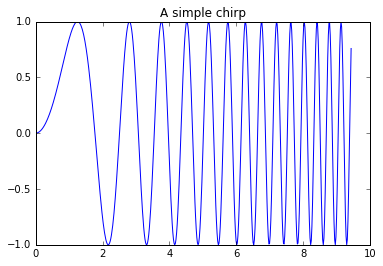

In [4]:
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp');

In [3]:
class Point:
    """A 2 dimensional point"""
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __repr__(self):
        return "Point("+str(self.x)+","+str(self.y)+")"

In [263]:
class Box:
    def __init__(self, center, width):
        self.center = center
        self.width = width
    def divide(self, function):
        new_width = self.width / 3
        left_x = self.center.x - self.width/2 + new_width/2
        left = Box(Point(left_x, function(left_x)), new_width)
        right_x = self.center.x + self.width/2 - new_width/2
        right = Box(Point(right_x, function(right_x)), new_width)
        
        return (left, Box(self.center, new_width), right)
    def lowerBound(self, K):
        """Return the lower bound of the function on this box assuming that center is on 
        the function and K is a positive Lipschitz constant for the function"""
        return self.center.y-self.maxErr(K)
    def maxErr(self, K):
        """Return the maximum error between taking the center of this box as the optimum and finding the
        real optimum within the box assiming that K is a positive Lipschitz constant for the function"""
        return (self.width/2)*K
    def __repr__(self):
        return "Box("+str(self.center)+","+str(self.width)+")"

In [269]:
def flatten(container):
    for i in container:
        if isinstance(i, list) or isinstance(i, tuple):
            for j in flatten(i):
                yield j
        else:
            yield i

In [178]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [175]:
def lipschitzControlPoints(numPoints, K):
    """The control points for a piecewise linear function on 0..1 whose Lipschitz constant is K
    
       return a sequence of Point objects that when connected by lines form a Lipschitz continuous function whose
       minimum positive (or maximum negative) constant is K and whose first point is chosen uniformly in the 
       interval [0,1]
    
       numPoints the number of points to generate: must be 2 or more
    
       K   the constant such that abs(x0-x1) <= k(f(x0)-f(x1))
    """
    xval=[0,1];xval.extend([rng.uniform(0,1) for i in range(1,numPoints-1)])
    xval.sort()
    xWithMaxK = rng.choice(xval[1:]) # This point will have a constant of exactly K
    def nextPt(x, y, newx):
        """Choose a random y value for the next point meeting the Lipschitz condition """
        dx = abs(newx-x)
        maxy = y + dx*K
        miny = y - dx*K
        if newx == xWithMaxK:
            return rng.choice([miny, maxy]) # This point will have a constant of exactly K
        else:
            return rng.uniform(miny, maxy)
    
    yval = [0] * len(xval)
    yval[0] = 0 # rng.uniform(0,1)
    for i in range(1,len(xval)):
        yval[i] = nextPt(xval[i-1], yval[i-1], xval[i])
    return [Point(i[0], i[1]) for i in zip(xval, yval)]
    

In [214]:
def slopes(points):
    """Takes a set of control points and returns the slope for each line-segment (n-1 segments for n points)"""
    return [(p[1].y-p[0].y)/(p[1].x-p[0].x) for p in pairwise(points)]

In [232]:
def lipschitzConstant(points):
    """Takes a set of control points and returns the minimum positive Lipschitz constant for that set"""
    return max([abs(slope) for slope in slopes(points)])

In [255]:
def funcMinimum(points):
    """Returns the minimum of a function defined on a set of control points"""
    return min([p.y for p in points])

In [249]:
def funcFromPoints(points):
    """Makes a function that linearly interpolates for the control points (error for out of bounds)"""
    return interpolate.interp1d([p.x for p in points], [p.y for p in points],'linear')

In [324]:
def schubertOneStep(boxes, minErr, minFound, func, K):
        # Among all the boxes whose lower bound is better than the best known, divide the box with the 
        # best center value
        potentiallyOptimal = [boxPr for boxPr in enumerate(boxes) if boxPr[1].lowerBound(K) <= minFound]
        toDivideIdx, toDivide = min(potentiallyOptimal, key=lambda p:p[1].center.y)
        newBoxes = toDivide.divide(func)
        boxes[toDivideIdx] = newBoxes[0]
        boxes.extend(newBoxes[1:])
        minFound = min([box.center.y for box in boxes])
        minLowerBound = min([box.lowerBound(K) for box in boxes])
        minErr = minFound - minLowerBound
        return boxes, minErr, minFound
    
def schubertAlgorithm(center,width,err,func,K):
    """Returns the best point (and all points tried) on func given that it is Lipschitz continuous with constant K 
    
       center the center x value of the interval over which the optimization takes place
       width the width of the interval over which the optimization takes place
       err the maximum error allowed - the iteration will stop when the lower bound is within 
           err of the best point
       func the function to optimize
       K the lipschitz constant for the interval
    """
    boxes = [Box(Point(center,func(center)), width)]
    minFound = min([box.center.y for box in boxes])
    minLowerBound = min([box.lowerBound(K) for box in boxes])
    minErr = minFound - minLowerBound
    while(minErr > err):
        boxes, minErr, minFound = schubertOneStep(boxes, minErr, minFound, func, K)
    best = [box for box in boxes if box.center.y == minFound]
    return best[0].center,boxes

In [250]:
cp=lipschitzControlPoints(5,3); cp

[Point(0,0),
 Point(0.024272971425798318,0.06662415274011171),
 Point(0.3794110287985284,1.132038324858302),
 Point(0.6319255904081468,1.78370142363673),
 Point(1,1.55374817228621)]

In [251]:
lipschitzConstant(cp)

3.0

(-2, 2)

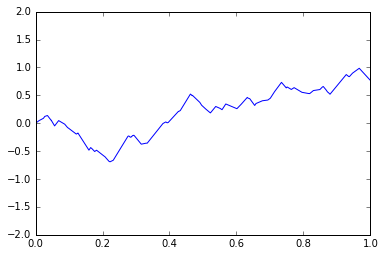

In [252]:
cp=lipschitzControlPoints(100,10)
y = [p.y for p in cp]
plt.plot([p.x for p in cp],y)
plt.ylim([y[0]-2,y[0]+2]) # Without this, the autoscaling makes all runs look the same

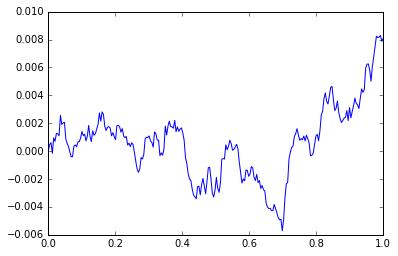

In [311]:
globalK=10
cp=lipschitzControlPoints(1000000,globalK)
fn=funcFromPoints(cp)
x = np.linspace(0, 1, 250)
plt.plot(x,[fn(xx) for xx in x])

In [315]:
funcMinimum(cp)

-0.005822518833219844

In [323]:
best,boxes=schubertAlgorithm(0.5,1,0.00001,fn,globalK); (best,len(boxes))

KeyboardInterrupt: 

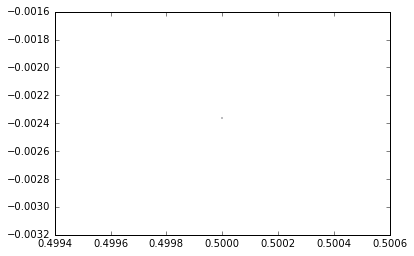

In [321]:
plt.scatter([box.center.x for box in boxes],[box.center.y for box in boxes],s=.1)
#plt.scatter([box.center.x for box in boxes],[box.lowerBound(globalK) for box in boxes],s=.1)

In [54]:
xsq=lambda x:x*x

In [63]:
divided = b.divide(xsq)

In [64]:
divided

(Box(Point(-6.0,36.0),6.0), Box(Point(0,0),6.0), Box(Point(6.0,36.0),6.0))

In [65]:
divided = list(flatten([x.divide(xsq) for x in divided]))

In [66]:
divided

[Box(Point(-8.0,64.0),2.0),
 Box(Point(-6.0,36.0),2.0),
 Box(Point(-4.0,16.0),2.0),
 Box(Point(-2.0,4.0),2.0),
 Box(Point(0,0),2.0),
 Box(Point(2.0,4.0),2.0),
 Box(Point(4.0,16.0),2.0),
 Box(Point(6.0,36.0),2.0),
 Box(Point(8.0,64.0),2.0)]